In [1]:
import jupyter_utils as j

j.reload(j)

In [14]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as split
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score

from matplotlib import pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

j.apply_options(pd)
j.reload(j)

%matplotlib inline

In [47]:
data = pd.read_csv('sparkify_data.csv')
data = data.drop(['userId'] ,axis = 1)

In [48]:
data.head(5)

,time_window,male,paid,canc,a_acti,a_adde,a_ads,a_disl,a_erro,a_frie,a_help,a_home,a_like,a_play,a_sett,a_song,a_stim,a_tiaw,n_acti,n_adde,n_ads,n_disl,n_down,n_erro,n_frie,n_help,n_home,n_like,n_sess,n_sett,n_song,n_upgr
0,73.035000,0,0,1,68.500000,0.500000,11.000000,1.500000,0.0,1.500000,0.000000,1.500000,2.0,3.593188,0.000000,48.000000,3.507733,73.035000,137,1,22,3,0,0,3,0,3,4,2,0,96,0
1,689.887778,1,0,1,79.000000,1.200000,2.200000,1.000000,0.0,0.400000,0.200000,4.600000,3.0,4.371990,0.400000,62.000000,5.758219,175.430139,395,6,11,5,0,0,2,1,23,15,5,2,310,1
2,197.078611,0,1,1,30.400000,0.600000,1.800000,0.000000,0.0,0.400000,0.400000,1.400000,1.6,1.573008,0.200000,22.400000,2.761294,50.922292,152,3,9,0,0,0,2,2,7,8,5,1,112,1
3,1049.074444,1,0,0,28.000000,0.666667,2.000000,0.333333,0.0,1.000000,0.666667,0.666667,1.0,1.464238,1.000000,20.666667,2.938208,526.337917,84,2,6,1,0,0,3,2,2,3,3,3,62,0
4,983.875833,0,1,1,126.823529,2.647059,0.058824,0.882353,0.0,1.529412,0.588235,4.117647,6.0,7.928195,0.882353,107.411765,14.717388,67.978194,2156,45,1,15,0,0,26,10,70,102,17,15,1826,0


In [100]:
def plot_roc_curve(y_test, y_predictions, model):
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = 'darkorange', label = model.__class__.__name__)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve (area = {np.around(auc, 4)})')
    plt.legend(loc = 'best')
    plt.show()
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[0, 0]
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('F1 macro.................%7.4f' % f1_score(y_test, y_predictions, average = 'macro'))
    print('F1 micro.................%7.4f' % f1_score(y_test, y_predictions, average = 'micro'))
    print('F1 weighted..............%7.4f' % f1_score(y_test, y_predictions, average = 'weighted'))
    # f1 = (2 * tp ) / (2 * tp + fp + fn) - f1_score with average 'binary'
    print('F1 binary................%7.4f' % f1_score(y_test, y_predictions, average = 'binary'))
    
def train_model(df, label, classifier): 

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = .3, random_state = 42)
    
    model = classifier.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model)
    plot_metrics(y_test, y_predicted)
    
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model)
    plot_metrics(y_test, y_predicted)
    
    return model

def train_random_forest(df, label):
    
    cl = RandomForestClassifier(n_estimators = 100, n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    return train_model(df, label, cl)

def train_logistic_regression(df, label):
    
    lr = LogisticRegression(solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced', random_state = 42)
    return train_model(df, label, lr)

def train_gradient_boosting(df, label):
    
    gbl = GradientBoostingClassifier(n_estimators = 200, max_depth = 4, learning_rate = 0.05, random_state = 42)
    return train_model(df, label, gbl)


In [50]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

# Filter average or absolute columns
features_to_normalize = list(filter(lambda column_name: '_' in column_name, data.columns))

_x = data.copy()
_x[features_to_normalize] = Normalizer().fit_transform(_x[features_to_normalize])
_x = _x.drop(list(filter(lambda column_name: 'n_' in column_name, _x.columns)), axis = 1)

_x.head(5)

,time_window,male,paid,canc,a_acti,a_adde,a_ads,a_disl,a_erro,a_frie,a_help,a_home,a_like,a_play,a_sett,a_song,a_stim,a_tiaw
0,0.339281,0,0,1,0.318214,0.002323,0.051100,0.006968,0.0,0.006968,0.000000,0.006968,0.009291,0.016692,0.000000,0.222982,0.016295,0.339281
1,0.786204,1,0,1,0.090029,0.001368,0.002507,0.001140,0.0,0.000456,0.000228,0.005242,0.003419,0.004982,0.000456,0.070656,0.006562,0.199922
2,0.702226,0,1,1,0.108321,0.002138,0.006414,0.000000,0.0,0.001425,0.001425,0.004988,0.005701,0.005605,0.000713,0.079815,0.009839,0.181445
3,0.889876,1,0,0,0.023751,0.000565,0.001696,0.000283,0.0,0.000848,0.000565,0.000565,0.000848,0.001242,0.000848,0.017530,0.002492,0.446465
4,0.327921,0,1,1,0.042270,0.000882,0.000020,0.000294,0.0,0.000510,0.000196,0.001372,0.002000,0.002642,0.000294,0.035800,0.004905,0.022657


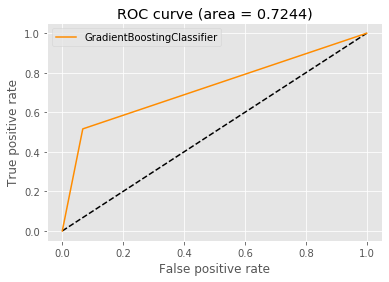

[[16 15]
 [ 7 97]]

accuracy................. 0.8370
precision................ 0.8661
recall................... 0.9327
auc...................... 0.7244
F1 macro................. 0.7454
F1 micro................. 0.8370
F1 weighted.............. 0.8280
F1 binary................ 0.5926


In [101]:
model = train_gradient_boosting(_x, 'canc')

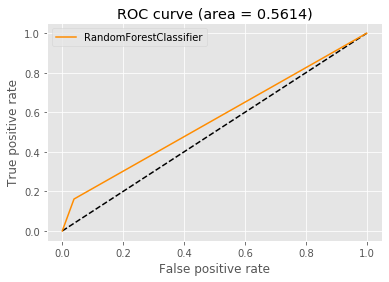

[[  5  26]
 [  4 100]]

accuracy................. 0.7778
precision................ 0.7937
recall................... 0.9615
auc...................... 0.5614
F1 macro................. 0.5598
F1 micro................. 0.7778
F1 weighted.............. 0.7273
F1 binary................ 0.2500


In [102]:
model = train_random_forest(_x, 'canc')

In [178]:
importances = pd.Series(model.feature_importances_, index = average_columns).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

,feature,importance
15,a_tiaw,0.226655
4,a_ads,0.091113
7,a_frie,0.074206
12,a_sett,0.070699
14,a_stim,0.062887
2,a_acti,0.059257
9,a_home,0.058633
13,a_song,0.058118
10,a_like,0.053512
11,a_play,0.053166


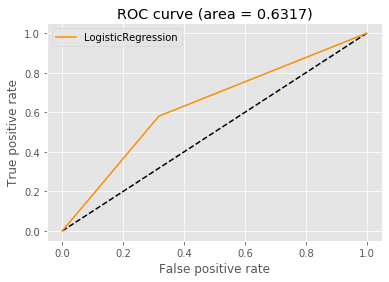

[[71 33]
 [13 18]]

accuracy................. 0.6593
precision................ 0.3529
recall................... 0.5806
auc...................... 0.6317
F1 macro................. 0.5972
F1 micro................. 0.6593
F1 weighted.............. 0.6827
F1 binary................ 0.4390


In [12]:
model = train_logistic_regression(_x, 'canc')

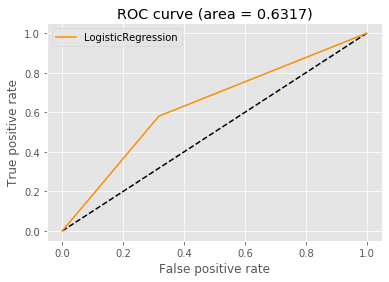

[[18 13]
 [33 71]]

accuracy................. 0.6593
precision................ 0.8452
recall................... 0.6827
auc...................... 0.6317
F1 macro................. 0.5972
F1 micro................. 0.6593
F1 weighted.............. 0.6827
F1 binary................ 0.4390


In [103]:
model = train_logistic_regression(_x, 'canc')

In [13]:
model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)